# Introduction.

These are some (modest) attempts at participating in Jigsaw's toxic comments classification problem. For now, I am not using any external data, only the training data given (which is limiting as it's a tiny dataset).

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
import keras
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


# Load Data

In [2]:
df = pd.read_csv('data/toxicity_annotated_comments_unanimous.tsv', sep='\t')

In [3]:
df.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,527004.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2002,True,user,random,test
1,603474.0,`:Here I cannot answer your questions. I did ...,2003,True,article,random,train
2,808576.0,"NEWLINE_TOKENNEWLINE_TOKENIn fact, I've just d...",2003,True,user,random,dev
3,986363.0,16:13 1 Jun 2003 (UTC),2003,True,article,random,train
4,1433843.0,NEWLINE_TOKENNEWLINE_TOKEN:I replied on .,2003,True,user,random,train


In [4]:
len(df)

3582

In [5]:
scores = pd.read_csv('data/toxicity_annotations_unanimous.tsv',  sep='\t')

In [6]:
scores.head(10)

,rev_id,worker_id,toxicity,toxicity_score
0,527004.0,3802,0,0.0
1,527004.0,3942,0,0.0
2,527004.0,590,0,0.0
3,527004.0,481,0,0.0
4,527004.0,3944,0,0.0
5,527004.0,4172,0,0.0
6,527004.0,2419,0,0.0
7,527004.0,3323,0,0.0
8,527004.0,2851,0,0.0
9,527004.0,4175,0,0.0


In [7]:
scores.drop_duplicates(subset='rev_id', inplace=True)

In [8]:
len(scores)

3582

In [9]:
df = df.merge(scores, on='rev_id', how='inner')

In [10]:
len(df)

3582

In [12]:
df.head(10)

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,toxicity,toxicity_score
0,527004.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2002,True,user,random,test,3802,0,0.0
1,603474.0,`:Here I cannot answer your questions. I did ...,2003,True,article,random,train,3278,0,0.0
2,808576.0,"NEWLINE_TOKENNEWLINE_TOKENIn fact, I've just d...",2003,True,user,random,dev,809,0,0.0
3,986363.0,16:13 1 Jun 2003 (UTC),2003,True,article,random,train,1081,0,0.0
4,1433843.0,NEWLINE_TOKENNEWLINE_TOKEN:I replied on .,2003,True,user,random,train,2794,0,0.0
5,1988528.0,NEWLINE_TOKENHA AH AHA HAHAHAHHAHAHAHHAHAH,2003,False,user,random,train,3374,0,0.0
6,1988988.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKEN Reques...,2003,True,user,random,train,1028,0,0.0
7,2078042.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2003,True,user,random,train,2059,0,0.0
8,2747887.0,NEWLINE_TOKENNEWLINE_TOKENOh - well - if you p...,2004,True,user,random,test,1993,0,0.0
9,2850252.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2004,True,user,random,test,561,0,0.0


In [13]:
df.drop(columns=['year', 'logged_in', 'split', 'ns', 'sample'], inplace=True)

In [14]:
df.head(10)

,rev_id,comment,worker_id,toxicity,toxicity_score
0,527004.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,3802,0,0.0
1,603474.0,`:Here I cannot answer your questions. I did ...,3278,0,0.0
2,808576.0,"NEWLINE_TOKENNEWLINE_TOKENIn fact, I've just d...",809,0,0.0
3,986363.0,16:13 1 Jun 2003 (UTC),1081,0,0.0
4,1433843.0,NEWLINE_TOKENNEWLINE_TOKEN:I replied on .,2794,0,0.0
5,1988528.0,NEWLINE_TOKENHA AH AHA HAHAHAHHAHAHAHHAHAH,3374,0,0.0
6,1988988.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKEN Reques...,1028,0,0.0
7,2078042.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2059,0,0.0
8,2747887.0,NEWLINE_TOKENNEWLINE_TOKENOh - well - if you p...,1993,0,0.0
9,2850252.0,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,561,0,0.0


In [15]:
df['comment'] = df['comment'].apply(lambda x: re.sub('NEWLINE_TOKEN', '', x))

In [16]:
df['toxic'] = df['toxicity_score'].apply(lambda x: int(x < 0))

In [17]:
df.drop(columns=['toxicity', 'toxicity_score'], inplace=True)

In [18]:
df.sort_values(['toxic'], ascending=False, inplace=True)

In [20]:
df.head(10)

,rev_id,comment,worker_id,toxic
3581,699660419.0,what ever you fuggin fagQuestion how did you k...,642,1
2507,459810020.0,"==You absolute spastic==I am right, Username72...",784,1
846,145045349.0,Racist? Are you crazy? I thought that you we...,695,1
2789,516983664.0,Intro should say that the Tea Party are a whit...,877,1
824,140385226.0,it should be biased against those soulless fuc...,340,1
2829,528187898.0,==message to attackers==Leave him alone. what ...,1393,1
2831,528427363.0,this is your last warning stop violating multi...,3942,1
778,129871433.0,YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK Y...,3330,1
2845,531565847.0,"`::::::::::::::::::::::::I've told you, in goo...",597,1
2852,532661527.0,==TIME?==Talk about unprofessional garbage. Th...,3720,1


# Pre-process

In [21]:
simple_tokens = df.comment.apply(gensim.utils.simple_preprocess)

In [22]:
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)

In [23]:
tokenized_text = list(tokenizer[simple_tokens])

In [24]:
tokenized_text[0]

['what',
 'ever',
 'you',
 'fuggin',
 'fagquestion',
 'how',
 'did',
 'you',
 'know',
 'they',
 'were',
 'not',
 'mine']

In [25]:
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)

In [26]:
df.columns

Index(['rev_id', 'comment', 'worker_id', 'toxic'], dtype='object')

In [27]:
TARGET_CLASSES = ['toxic']
targets = df[TARGET_CLASSES].values

In [28]:
targets

array([[1],
       [1],
       [1],
       ..., 
       [0],
       [0],
       [0]])

# Analysis

(0, 400)

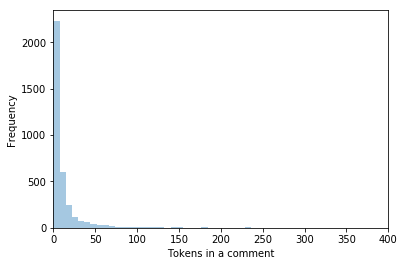

In [29]:
sns.distplot([len(doc) for doc in tokenized_text], bins=100, kde=False, label='Number of tokens per comment.')
plt.xlabel("Tokens in a comment")
plt.ylabel("Frequency")
plt.xlim((0, 400))

# Training word2vec on comment data.

In [30]:
word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)

In [31]:
word2vec.wv.most_similar('citation')

[('been', 0.999602735042572),
 ('the_same', 0.9995899200439453),
 ('am', 0.9995876550674438),
 ('very', 0.9995816349983215),
 ('time', 0.9995666146278381),
 ('before', 0.9995635747909546),
 ('section', 0.9995619058609009),
 ('another', 0.9995591044425964),
 ('editing', 0.9995579123497009),
 ('has', 0.9995574951171875)]

In [32]:
word2vec.wv.most_similar('fuck')

[('always', 0.9978344440460205),
 ('best', 0.9975923895835876),
 ('do_not', 0.9975626468658447),
 ('christopher', 0.9975571632385254),
 ('hunter', 0.9975089430809021),
 ('are_foreigners', 0.9974634647369385),
 ('world', 0.9974256753921509),
 ('history', 0.9973925948143005),
 ('sa_oi', 0.997319221496582),
 ('through', 0.9973117709159851)]

# word2vec-based based model.

Aggregate word embeddings per comment (~ tf-idf weighted averaging), and use that as an input feature in a neural net with one hidden layer.

In [33]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

In [34]:
features.shape

(3582, 100)

In [35]:
targets.shape

(3582, 1)

In [36]:
len(TARGET_CLASSES)

1

In [37]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(word2vec.vector_size,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model.fit(features, targets, epochs=10, validation_split=0.1)

Train on 3223 samples, validate on 359 samples
Epoch 1/10
3223/3223 [==============================] - 1s 161us/step - loss: 0.2939 - acc: 0.9469 - val_loss: 0.0640 - val_acc: 1.0000
Epoch 2/10
3223/3223 [==============================] - 0s 51us/step - loss: 0.2071 - acc: 0.9469 - val_loss: 0.0427 - val_acc: 1.0000
Epoch 3/10
3223/3223 [==============================] - 0s 49us/step - loss: 0.2090 - acc: 0.9469 - val_loss: 0.0647 - val_acc: 1.0000
Epoch 4/10
3223/3223 [==============================] - 0s 52us/step - loss: 0.2063 - acc: 0.9469 - val_loss: 0.0540 - val_acc: 1.0000
Epoch 5/10
3223/3223 [==============================] - 0s 48us/step - loss: 0.2070 - acc: 0.9469 - val_loss: 0.0628 - val_acc: 1.0000
Epoch 6/10
3223/3223 [==============================] - 0s 51us/step - loss: 0.2051 - acc: 0.9469 - val_loss: 0.0343 - val_acc: 1.0000
Epoch 7/10
3223/3223 [==============================] - 0s 48us/step - loss: 0.2063 - acc: 0.9469 - val_loss: 0.0614 - val_acc: 1.0000
Epoch 8

# Sequential models

Simply averaging embeddings across all terms in a comment loses interactions that can occur between words, and the importance of their position. Because of this, we will now experiment with position-aware models: LSTM and CNN.

In [39]:
# Note: shifting indices by 1 as index 0 will be used for padding.
docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]

In [40]:
MAX_SEQ_LEN = 50
padded_docs = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

In [41]:
max_idx = max(c for d in docs for c in d)
max_idx

9957

In [42]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ # for the '0' padding word
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])

## CNN

In [43]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPool1D, Flatten, BatchNormalization

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(52, 5, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(128, 3, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid',
                kernel_regularizer=keras.regularizers.l2(0.02)))
model.compile(Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model.fit(padded_docs, targets, batch_size=512, epochs=20, validation_split=0.1)

Train on 3223 samples, validate on 359 samples
Epoch 1/20
3223/3223 [==============================] - 2s 701us/step - loss: 1.7133 - acc: 0.9153 - val_loss: 1.8461 - val_acc: 1.0000
Epoch 2/20
3223/3223 [==============================] - 1s 390us/step - loss: 1.5117 - acc: 0.9460 - val_loss: 1.6800 - val_acc: 1.0000
Epoch 3/20
3223/3223 [==============================] - 1s 380us/step - loss: 1.3427 - acc: 0.9485 - val_loss: 1.5959 - val_acc: 1.0000
Epoch 4/20
3223/3223 [==============================] - 1s 400us/step - loss: 1.1970 - acc: 0.9497 - val_loss: 1.4288 - val_acc: 1.0000
Epoch 5/20
3223/3223 [==============================] - 1s 415us/step - loss: 1.0619 - acc: 0.9510 - val_loss: 1.2637 - val_acc: 1.0000
Epoch 6/20
3223/3223 [==============================] - 1s 431us/step - loss: 0.9348 - acc: 0.9572 - val_loss: 1.1461 - val_acc: 1.0000
Epoch 7/20
3223/3223 [==============================] - 1s 394us/step - loss: 0.8233 - acc: 0.9594 - val_loss: 0.9982 - val_acc: 1.0000
E

# Creating a submission.

In [45]:
def comment_to_sequential_input(comment):
    tokens = tokenizer[gensim.utils.simple_preprocess(comment)]
    t_ids = [corpus_dict.token2id[t] + 1 for t in tokens if t in word2vec.wv.vocab and t in corpus_dict.token2id]
    return keras.preprocessing.sequence.pad_sequences([t_ids], maxlen=MAX_SEQ_LEN)[0]

In [46]:
test_input = [comment_to_sequential_input("Why are we having all these people from shithole countries come here?").reshape(1, -1)]
for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
    print("{}: {:.2f}%".format(target_class, score * 100))

toxic: 11.80%


In [47]:
model.predict_proba(test_input)

array([[ 0.1180065]], dtype=float32)

In [48]:
test_text = df.iloc[0].comment

In [49]:
test_input = [comment_to_sequential_input(test_text).reshape(1, -1)]
for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
    print("{}: {:.2f}%".format(target_class, score * 100))

toxic: 13.14%


In [50]:
test_text = "Now is the time for all good persons to come to the aid of their country"

In [51]:
test_input = [comment_to_sequential_input(test_text).reshape(1, -1)]
for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
    print("{}: {:.2f}%".format(target_class, score * 100))

toxic: 11.36%


In [ ]:
test_inputs = np.array([comment_to_sequential_input(doc) for doc in df_test.comment_text])

In [ ]:
test_outputs = model.predict_classes(test_inputs)

In [ ]:
test_outputs[0]

In [ ]:
output_df = df_test.reset_index()[['id']].copy()

In [ ]:
for i, target_class in enumerate(TARGET_CLASSES):
    output_df[target_class] = test_outputs[:, i]

In [ ]:
output_df[output_df.toxic > 0.5].sample(10, random_state=0).merge(df_test.reset_index(), on='id')

In [ ]:
output_df.to_csv('submissions/cnn_0.csv', index=False)

# Annex

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution1D, Dense

model = Sequential()
model.add(Embedding(word2vec.vector_size))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def tokens_to_embedding(tokens):
    embeddings = [word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens if t in word2vec.wv.vocab]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec.vector_size)

def text_to_embedding(text):
    return tokens_to_embedding(tokenizer[gensim.utils.simple_preprocess(text)])

text = 'hello moroccan friend is just a regular message without any insults'
model.predict(text_to_embedding(text).reshape(1, -1))

In [ ]:
test_tokens = tokenizer[df_test.comment_text.apply(gensim.utils.simple_preprocess)]

In [ ]:
test_features = [tokens_to_embedding(tokens) for tokens in test_tokens]